In [1]:
from ipywidgets import FileUpload
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import io
import random

In [2]:
uploader = FileUpload()
uploader

FileUpload(value={}, description='Upload')

In [3]:
file = list(uploader.value.values())[0]
content = file['content']
content = io.StringIO(content.decode('utf-8'))
df = pd.read_csv(content)

In [4]:
df.columns

Index(['id', 'gender', 'age', 'hypertension', 'heart_disease', 'ever_married',
       'work_type', 'Residence_type', 'avg_glucose_level', 'bmi',
       'smoking_status', 'stroke'],
      dtype='object')

In [5]:
df.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


In [6]:
df.describe()

,id,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
count,5110.000000,5110.000000,5110.000000,5110.000000,5110.000000,4909.000000,5110.000000
mean,36517.829354,43.226614,0.097456,0.054012,106.147677,28.893237,0.048728
std,21161.721625,22.612647,0.296607,0.226063,45.283560,7.854067,0.215320
min,67.000000,0.080000,0.000000,0.000000,55.120000,10.300000,0.000000
25%,17741.250000,25.000000,0.000000,0.000000,77.245000,23.500000,0.000000
50%,36932.000000,45.000000,0.000000,0.000000,91.885000,28.100000,0.000000
75%,54682.000000,61.000000,0.000000,0.000000,114.090000,33.100000,0.000000
max,72940.000000,82.000000,1.000000,1.000000,271.740000,97.600000,1.000000


In [7]:
df = df.drop(columns = ['id'])

In [8]:
df.isna().sum()

gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
Residence_type         0
avg_glucose_level      0
bmi                  201
smoking_status         0
stroke                 0
dtype: int64

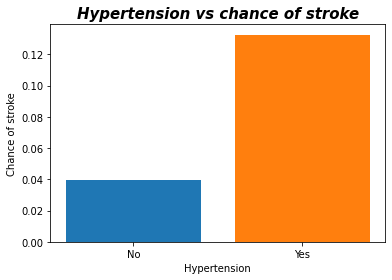

In [9]:
yesno = [ 'No', 'Yes']
ax = plt.subplot()

for i in range(2):
  plt.bar(i, df[(df['hypertension'] == i)]['stroke'].mean())

ax.set_xlabel('Hypertension')
ax.set_ylabel('Chance of stroke')
ax.set_xticks(range(2))
ax.set_xticklabels(yesno)

plt.title('Hypertension vs chance of stroke', fontweight = 'bold', fontstyle = 'italic', fontsize = 15)

plt.show()

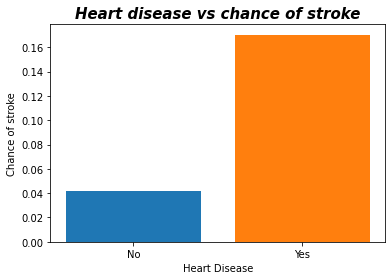

In [10]:
yesno = [ 'No', 'Yes']
ax = plt.subplot()

for i in range(2):
  plt.bar(i, df[(df['heart_disease'] == i)]['stroke'].mean())

ax.set_xlabel('Heart Disease')
ax.set_ylabel('Chance of stroke')
ax.set_xticks(range(2))
ax.set_xticklabels(yesno)

plt.title('Heart disease vs chance of stroke', fontweight = 'bold', fontstyle = 'italic', fontsize = 15)
plt.show()

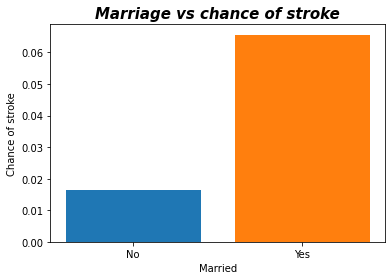

In [11]:
yesno = [ 'No', 'Yes']
ax = plt.subplot()

for i in range(2):
  plt.bar(i, df[(df['ever_married'] == yesno[i])]['stroke'].mean())

ax.set_xlabel('Married')
ax.set_ylabel('Chance of stroke')
ax.set_xticks(range(2))
ax.set_xticklabels(yesno)

plt.title('Marriage vs chance of stroke', fontweight = 'bold', fontstyle = 'italic', fontsize = 15)

plt.show()

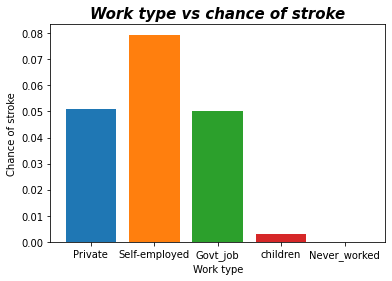

In [12]:
work_type = list(df['work_type'].unique())
ax = plt.subplot()

for i in range(len(work_type)):
  plt.bar(i, df[(df['work_type'] == work_type[i])]['stroke'].mean())

ax.set_xlabel('Work type')
ax.set_ylabel('Chance of stroke')
ax.set_xticks(range(len(work_type)))
ax.set_xticklabels(work_type)

plt.title('Work type vs chance of stroke', fontweight = 'bold', fontstyle = 'italic', fontsize = 15)
plt.show()

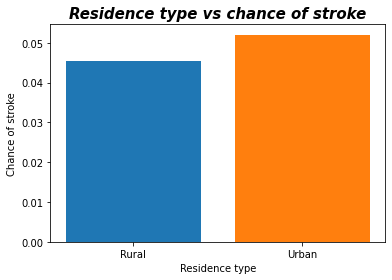

In [13]:
area = [ 'Rural', 'Urban']
ax = plt.subplot()

for i in range(len(area)):
  plt.bar(i, df[(df['Residence_type'] == area[i])]['stroke'].mean())

ax.set_xlabel('Residence type')
ax.set_ylabel('Chance of stroke')
ax.set_xticks(range(len(area)))
ax.set_xticklabels(area)

plt.title('Residence type vs chance of stroke', fontweight = 'bold', fontstyle = 'italic', fontsize = 15)
plt.show()

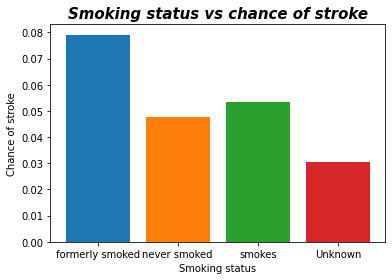

In [14]:
smoking_labels = list(df['smoking_status'].unique())

ax = plt.subplot()

for i in range(len(smoking_labels)):
  plt.bar(i, df[(df['smoking_status'] == smoking_labels[i])]['stroke'].mean())

ax.set_xlabel('Smoking status')
ax.set_ylabel('Chance of stroke')
ax.set_xticks(range(len(smoking_labels)))
ax.set_xticklabels(smoking_labels)

plt.title('Smoking status vs chance of stroke', fontweight = 'bold', fontstyle = 'italic', fontsize = 15)
plt.show()

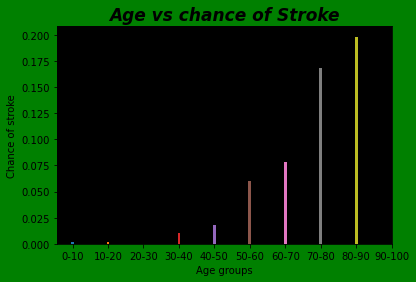

In [15]:
age_groups = [f'{i}-{i+10}' for i in range(0, 100, 10)]
fig, ax = plt.subplots()

for i in range(0, 100, 10):
  plt.bar(i, df[(df['age'] <i+10) & (df['age'] > i)]['stroke'].mean())

ax.set_xlabel('Age groups')
ax.set_ylabel('Chance of stroke')
ax.set_xticks(range(0, 100, 10))
ax.set_xticklabels(age_groups)
ax.set_facecolor('black')
rect = fig.patch
rect.set_facecolor('green')

plt.title('Age vs chance of Stroke', fontweight = 'bold', fontstyle = 'italic', fontsize = 17)

plt.show()

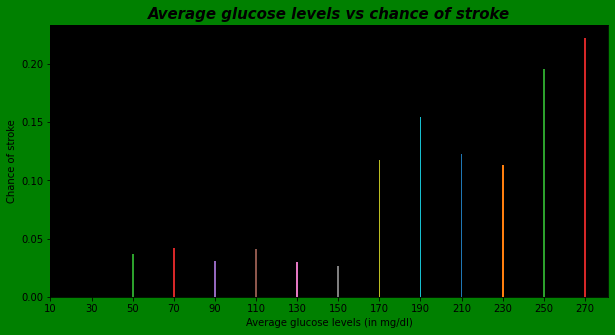

In [16]:
avg_glucose_levels = [f'{i+10}' for i in range(0, 280, 20)]
fig, ax = plt.subplots()

for i in range(0, 280, 20):
  plt.bar(i, df[(df['avg_glucose_level'] <i+20) & (df['avg_glucose_level'] > i)]['stroke'].mean())

ax.set_xlabel('Average glucose levels (in mg/dl)')
ax.set_ylabel('Chance of stroke')
ax.set_xticks(range(0, 280, 20))
ax.set_xticklabels(avg_glucose_levels)
ax.set_facecolor('black')
rect = fig.patch
rect.set_facecolor('green')
fig.set_figwidth(10)
fig.set_figheight(5)

plt.title('Average glucose levels vs chance of stroke', fontweight = 'bold', fontstyle = 'italic', fontsize = 15)
plt.show()

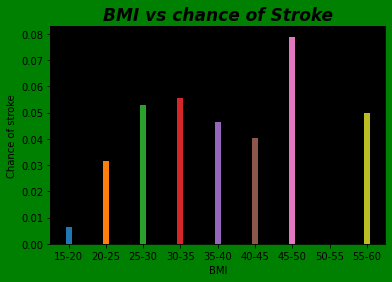

In [17]:
age_groups = [f'{i}-{i+5}' for i in range(15, 60, 5)]
fig, ax = plt.subplots()

for i in range(15, 60, 5):
  plt.bar(i, df[(df['bmi'] < i+5) & (df['bmi'] > i)]['stroke'].mean())

ax.set_xlabel('BMI')
ax.set_ylabel('Chance of stroke')
ax.set_xticks(range(15, 60, 5))
ax.set_xticklabels(age_groups)
ax.set_facecolor('black')
rect = fig.patch
rect.set_facecolor('green')

plt.title('BMI vs chance of Stroke', fontweight = 'bold', fontstyle = 'italic', fontsize = 17)

plt.show()